# Quantum Newton Raphson on Net0 with QUBO linear solver

In this example, we use the QUBO solver to drive the Newton-Raphson algorithm to obtain the pressure and flow rate of a small network, Net0:

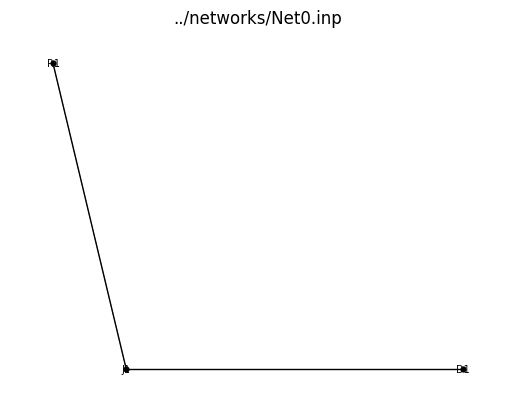

<Axes: title={'center': '../networks/Net0.inp'}>

In [1]:
import os
import wntr
import wntr_quantum

# if not done in shell, define the environment variable here
os.environ["EPANET_TMP"] = "/home/nico/.epanet_quantum"
os.environ["EPANET_QUANTUM"] = "/home/nico/QuantumApplicationLab/vitens/EPANET"

# set up network model
inp_file = "../networks/Net0.inp"
wn = wntr.network.WaterNetworkModel(inp_file)

# plot network
wntr.graphics.plot_network(wn, title=wn.name, node_labels=True)


In [2]:
# define the classical EPANET simulator
sim = wntr.sim.EpanetSimulator(wn)

# run the EPANET simulation
results_epanet = sim.run_sim()

# save number of nodes and pipes
n_nodes = (len(results_epanet.node["pressure"].iloc[0]),)
n_pipes = len(results_epanet.link["flowrate"].iloc[0])

results_epanet.node["pressure"], results_epanet.link["flowrate"]

(name         J1         D1            R1
 0     29.647692  19.167677 -9.338379e-07
 3600  29.647692  19.167677 -9.338379e-07,
 name    P1    P2
 0     0.05  0.05
 3600  0.05  0.05)

### Solve water network with `QuantumEpanetSimulator` and QUBOLS 

We now solve the model using QUBO as linear solver.

In [3]:
import numpy as np
from quantum_newton_raphson.qubo_solver import QUBO_SOLVER
from qubols.encodings import RangedEfficientEncoding
from utils import compare_results 

linear_solver = QUBO_SOLVER(
    encoding=RangedEfficientEncoding,
    num_qbits=15,
    num_reads=500,
    range=600,
    offset=0,
    iterations=5,
    temperature=1e4,
    use_aequbols=True,
)


sim = wntr_quantum.sim.QuantumEpanetSimulator(wn, linear_solver=linear_solver)
results_hhl = sim.run_sim(linear_solver=linear_solver)

classical_res, quantum_res = compare_results(results_epanet, results_hhl)

results_hhl.node["pressure"], results_hhl.link["flowrate"]

{'encoding': <class 'qubols.encodings.RangedEfficientEncoding'>, 'num_qbits': 15, 'num_reads': 500, 'range': 600, 'offset': 0, 'iterations': 5, 'temperature': 10000.0}
/home/nico/QuantumApplicationLab/vitens/wntr-quantum/wntr_quantum/epanet/Linux/libepanet22_amd64.so
0 [0, 0] 600
1 [83.93068750566246, 97.78428845681842] [291.7123485154465, 40.779379100099874]
2 [83.80933312276109, 97.77243716742858] [0.06971145194787838, 0.006262073439076494]
3 [83.80381155273764, 97.77218423667651] [0.0048006335566103935, 1.0]
4 [83.80128395213971, 97.7720668587892] [0.0013452135025622187, 1.0]
0 [0, 0] 600
1 [62.97510401606745, 97.2707667769409] [297.3172104056457, 40.84185941269238]
2 [62.92402430373457, 97.27036453641941] [0.05073755809990319, 0.002307871410698736]
3 [62.8868121231212, 97.26936272413894] [0.004333835883112672, 1.0]
4 [62.88625449128368, 97.26933171635251] [1.0, 1.0]
0 [0, 0] 600
1 [62.96311586689058, 97.26995491881586] [282.0665571804665, 38.5454027925069]
2 [62.911433818959374, 97

(name         J1         D1            R1
 0     29.647692  19.167711 -9.338379e-07
 3600  29.647707  19.167915 -9.338379e-07,
 name        P1        P2
 0     0.050000  0.050000
 3600  0.049999  0.049999)

### Plot pressures and flow rates

Let's check graphically the equivalence of the results.

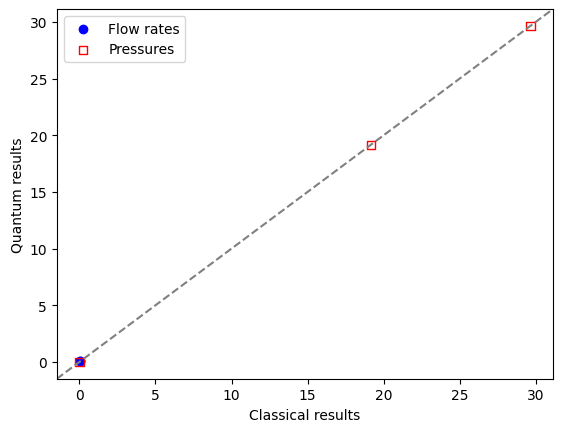

In [4]:
import matplotlib.pyplot as plt

plt.scatter(
    classical_res[:n_pipes],
    quantum_res[:n_pipes],
    label="Flow rates",
    color="blue",
    marker="o",
)
plt.scatter(
    classical_res[n_pipes:],
    quantum_res[n_pipes:],
    label="Pressures",
    color="red",
    marker="s",
    facecolors="none",
)
plt.axline((0, 0), slope=1, linestyle="--", color="gray", label="")
plt.xlabel("Classical results")
plt.ylabel("Quantum results")
plt.legend()
plt.show()

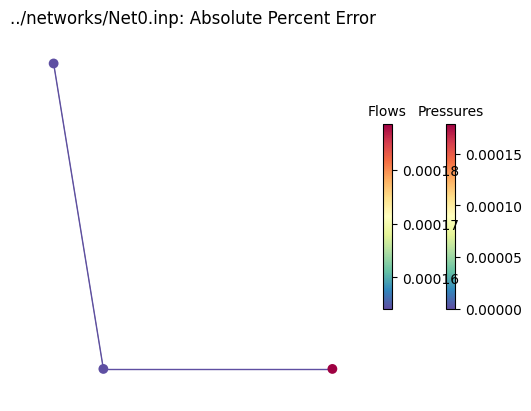

<Axes: title={'center': '../networks/Net0.inp: Absolute Percent Error'}>

In [5]:
from utils import get_ape_from_pd_series

wntr.graphics.plot_network(
    wn,
    node_attribute=get_ape_from_pd_series(
        results_hhl.node["pressure"].iloc[0], results_epanet.node["pressure"].iloc[0]
    ),
    link_attribute=get_ape_from_pd_series(
        results_hhl.link["flowrate"].iloc[0],
        results_epanet.link["flowrate"].iloc[0],
    ),
    node_colorbar_label="Pressures",
    link_colorbar_label="Flows",
    node_size=50,
    title=f"{inp_file}: Absolute Percent Error",
    node_labels=False,
)